In [1]:
import os
import sklearn
import numpy as np
import pandas as pd
import glob
import librosa 
from directory_tree import display_tree
path = r'/Users/frankconway/OneDrive/Strathclyde/Strathclyde/LadyCurranInternship/SVD/Data/'


In [2]:
def windows(audio, window_size):
    start = 0
    while start < len(audio):
        #len(audio) is the total number of sample points for an audio file.
        yield start, int(start) + window_size #Retrieve the sample point index index of length window_size
        start += (window_size / 2) #Calculate the starting position of the next segment

In [3]:
extracted_features_hel = pd.DataFrame(columns=['features','label','names','classification'])
extracted_features_ben = pd.DataFrame(columns=['features','label','names','classification'])
extracted_features_mal = pd.DataFrame(columns=['features','label','names','classification'])

def extract_features(parent_dir,sub_dirs,label,file_ext="*.wav",bands = 60, frames = 41):
    '''Wrangle audio data into 60x41x2 frames.
    Bands = 60 = number of MFCC
    frames = 41 = number of windows from the audio signal
    Number of channels (like R,G,B channels in images) = 2 = mel-
    spectrograms and their corresponding delta'''
    #
    
    window_size = 512 * (frames - 1) 
    log_specgrams = []
    labels = []
    names = []

    for l, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)): 
            #if "phrase" in fn : continue # only train on vowels
            sound_clip,s = librosa.load(fn)
            
            for (start,end) in windows(sound_clip,window_size):
                    
                feature = []
                start = int(start)
                end = int(end)
                #print(start, end)
                #print(type(start), start, type(end), end, window_size)
                if(len(sound_clip[start:end]) == window_size):
                    names.append(fn.replace(path,''))
                    
                    signal = sound_clip[start:end] # window the original audio
                    D = np.abs(librosa.stft(signal))**2
                    melspec = librosa.feature.melspectrogram(S=D, n_mels = bands) # length 0f 60
                    #print('melspec:', len(melspec))
                    logspec = librosa.amplitude_to_db(melspec) # length 0f 60 & normalized
                    #print('logspec:', len(logspec))
                    #logspec = logspec.T.flatten()[:, np.newaxis].T # Transposed list of MFCCs
                    #print('logspec final:', len(logspec)) 
                    feature.append(logspec)
                    
                    melspec = librosa.feature.melspectrogram(y=signal, n_mels = bands)
                    logspec = librosa.amplitude_to_db(melspec) 
                    #logspec = logspec.T.flatten()[:, np.newaxis].T 
                    feature.append(logspec)
                    
                    melspec = librosa.feature.mfcc(y=signal, sr=s, n_mfcc=bands) 
                    logspec = librosa.amplitude_to_db(melspec)
                    #logspec = logspec.T.flatten()[:, np.newaxis].T 
                    #print(feature)
                    feature.append(logspec)
                                     
                    # use perceptual linear prediction cepstral features (PLPs) 
                    log_specgrams.append(feature)
                    labels.append(label)
                  
    for i in range (0, len(log_specgrams)):
        log_specgrams[i] = np.array(log_specgrams[i])
        log_specgrams[i] = np.transpose(log_specgrams[i], (1, 2, 0))
                  
    data = { 'features' : log_specgrams,
            'label': labels,
            'names' : names
           }
    df = pd.DataFrame(data , columns=['features','label','names'])
    return df

In [4]:
## Data should be stored in directory fromat 
display_tree(path,max_depth=1)
display_tree(path+'/Structural',max_depth=1)

Data/
├── Functional/
├── Healthy/
├── Neurological/
├── Other/
├── Pathology/
└── Structural/
Structural/
├── Arytenoid_Subluxation/
├── Carcinoma_in_situ/
├── Chondrom/
├── cordotomy/
├── Cyst/
├── Epiglottis_carcinoma/
├── fibroma/
├── fistula/
├── frontolateral_partial_laryngectomy/
├── Granuloma/
├── hyperplasia/
├── hypopharynx_cancer/
├── intubation_damage/
├── intubation_granuloma/
├── laryngeal_tumor/
├── Medial_cervical_cyst/
├── nasopharyngeal_tumor/
├── Papilloma/
├── pocket_wrinkled_voice/
├── Rhinophonia_closed/
├── Rhinophonia_mixed/
├── Rhinophonia_open/
├── Vallecular_Cyst/
├── Velo_pharyngoplasty/
├── vocal_cord_polyp/
└── vocal_fold_carcinoma/


In [5]:
## load all data 

benign = ['Arytenoid_Subluxation','intubation_damage','fistula','Rhinophonia_closed', 
             'Rhinophonia_mixed','Rhinophonia_open','pocket_wrinkled_voice',
             'Vallecular_Cyst', 'Velo_pharyngoplasty' , 'Cyst','Medial_cervical_cyst',
            'hyperplasia']


malignant = ['fibroma','nasopharyngeal_tumor','Carcinoma_in_situ','Chondrom','Epiglottis_carcinoma',
       'hypopharynx_cancer','laryngeal_tumor', 'Papilloma', 'vocal_fold_carcinoma','vocal_cord_polyp']


#path = r"/SVD/Data/"

extracted_features_hel = extract_features(path, ["Healthy"],0)
extracted_features_ben = extract_features(path+"Structural", benign,1)
extracted_features_mal = extract_features(path+"Structural", malignant,2)

In [6]:
if len(extracted_features_ben) > len(extracted_features_mal):
    size = len(extracted_features_mal)
else:
    size = len(extracted_features_ben)

In [7]:
extracted_features_mal

,features,label,names
0,"[[[7.9065113, 7.9065113, 49.979515], [13.56918...",2,Structural/fibroma/106-u_n.wav
1,"[[[-19.338318, -19.338318, 53.457497], [-17.05...",2,Structural/fibroma/1781-phrase.wav
2,"[[[2.5532827, 2.5532827, 42.685364], [-2.80675...",2,Structural/fibroma/1781-phrase.wav
3,"[[[-10.462711, -10.462711, 51.537453], [0.8124...",2,Structural/fibroma/1781-phrase.wav
4,"[[[-5.1042185, -5.1042185, 52.849346], [-3.951...",2,Structural/fibroma/106-u_l.wav
...,...,...,...
1231,"[[[9.134085, 9.134085, 42.239227], [-0.8389913...",2,Structural/vocal_cord_polyp/1525-u_h.wav
1232,"[[[-2.9204144, -2.9204144, 47.15134], [-10.459...",2,Structural/vocal_cord_polyp/1525-u_h.wav
1233,"[[[24.312365, 24.312365, 30.67193], [24.090954...",2,Structural/vocal_cord_polyp/1576-a_l.wav
1234,"[[[7.024004, 7.024004, 43.06789], [8.528129, 8...",2,Structural/vocal_cord_polyp/1164-i_l.wav


In [32]:
## change values to 1 for Hel or Ben/Mal
## 2 for Hel or Ben or Mal 

temp = [0]*len(extracted_features_ben)

extracted_features_ben['label'] = temp

temp = [1]*len(extracted_features_mal)

extracted_features_mal['label'] = temp


In [33]:
## split data to train, val, test 
## X and y from features and lables
## X to list them to np array for training 
## create y matrix for training output

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

## creating train/test/val for all df
## all training will have same data in train/test/val

train_hel, test_hel = train_test_split(extracted_features_hel[:size*2], test_size=0.2 , random_state=42)
train_ben, test_ben = train_test_split(extracted_features_ben[:size], test_size=0.2 , random_state=42)
train_mal, test_mal = train_test_split(extracted_features_mal[:size], test_size=0.2 , random_state=42)


val_hel, test_hel = train_test_split(test_hel, test_size = 0.5,random_state=42)
val_ben, test_ben = train_test_split(test_ben, test_size = 0.5,random_state=42)
val_mal, test_mal = train_test_split(test_mal, test_size = 0.5,random_state=42)

## stage 0 & 1

# train = pd.concat([train_hel,train_ben,train_mal])
# test = pd.concat([test_hel,test_ben,test_mal])
# val = pd.concat([val_hel,val_ben,val_mal])

## stage 2

train = pd.concat([train_ben,train_mal])
test = pd.concat([test_ben,test_mal])
val = pd.concat([val_ben,val_mal])

# train = pd.concat([train_hel,train_ben])
# test = pd.concat([test_hel,test_ben])
# val = pd.concat([val_hel,val_ben])

# train = pd.concat([train_hel,train_mal])
# test = pd.concat([test_hel,test_mal])
# val = pd.concat([val_hel,val_mal])

print("train: ",len(train))
print("val: ", len(val))
print("test: ", len(test))

labelencoder=LabelEncoder()

X_train = train['features'].to_list()
X_val = val['features'].to_list()
X_test = test['features'].to_list()
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

y_train = train['label']
y_test = test['label']
y_val = val['label']
y_train = to_categorical(labelencoder.fit_transform(train['label']))
y_val = to_categorical(labelencoder.fit_transform(val['label']))
y_test = to_categorical(labelencoder.fit_transform(test['label']))

names_val = val['names']


train:  1382
val:  172
test:  174


In [34]:
print("X shape: ", X_test.shape)

X shape:  (174, 60, 41, 3)


In [35]:
## training Stage 
## stage 0 = Healthy / Malignant/ Benign => num_classes = 3
## stage 1 = Healthy / Malignant&Benign  => num_classes = 2
## stage 2 = Malignant / Benign          => num_classes = 2

num_classes = 2
stage = 'Biopsy/Stage2/'

In [56]:
import tensorflow as tf
import keras

# METRICS = [
#       keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
#       keras.metrics.MeanSquaredError(name='Brier score'),
#       keras.metrics.TruePositives(name='tp'),
#       keras.metrics.FalsePositives(name='fp'),
#       keras.metrics.TrueNegatives(name='tn'),
#       keras.metrics.FalseNegatives(name='fn'), 
#       keras.metrics.BinaryAccuracy(name='accuracy'),
#       keras.metrics.Precision(name='precision'),
#       keras.metrics.Recall(name='recall'),
#       keras.metrics.AUC(name='auc'),
#       keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
# ]

In [57]:
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,BatchNormalization
from tensorflow.keras.layers import Activation,MaxPooling2D,LeakyReLU


model = keras.Sequential()

# Layer 1 - Convolution with 24 filters + Maxpooling
model.add(Conv2D(64, (3,3), padding='valid', 
                input_shape=(60,41,3), strides=(1, 1)
                 ,kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2),
                       strides=(2, 2))) 

model.add(BatchNormalization(axis=1)) 
model.add(Dropout(0.5))
model.add(Activation('tanh'))

# Layer 2 - Convolution with 48 filters + Maxpooling 
model.add(Conv2D(64, (3,3)
                       ,kernel_regularizer=keras.regularizers.l2(0.001))) 
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2))) 
model.add(BatchNormalization(axis=1)) 
model.add(Dropout(0.5))
#model.add(Activation('relu'))
model.add(LeakyReLU(alpha=0.03))


# Layer 3 - Convolution with 24 filters + Maxpooling
model.add(Conv2D(64, (3,3), padding='valid',
                 ))
model.add(BatchNormalization(axis=1)) 
model.add(Dropout(0.5))
#model.add(Activation('relu'))
model.add(LeakyReLU(alpha=0.03))



model.add(layers.Flatten())
model.add(Dense(units=64, activation='LeakyReLU'))
model.add(Dense(units=num_classes, activation='sigmoid'))

# Model compilation
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])

In [58]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 58, 39, 64)        1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 29, 19, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 29, 19, 64)       116       
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 29, 19, 64)        0         
                                                                 
 activation_3 (Activation)   (None, 29, 19, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 27, 17, 64)       

In [59]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from datetime import datetime 

num_epochs = 1000
num_batch_size = 64

checkpointer = ModelCheckpoint(filepath=stage+'/CNN.hdf5', 
                               verbose=1,monitor='val_categorical_accuracy', save_best_only=True)
early = EarlyStopping(
    monitor='val_categorical_accuracy', 
    verbose=1,
    patience=100,
    mode='max',
    restore_best_weights=True)
start = datetime.now()

hist = model.fit(X_train,y_train , batch_size=num_batch_size, epochs=num_epochs, 
                 validation_data=(X_val, y_val), callbacks=[checkpointer,early,tensorboard_callback], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)


Epoch 1/1000
22/22 [==============================] - ETA: 0s - loss: 1.3784 - categorical_accuracy: 0.5014
Epoch 1: val_categorical_accuracy improved from -inf to 0.50000, saving model to Biopsay/Stage2/CNN.hdf5
22/22 [==============================] - 1s 35ms/step - loss: 1.3784 - categorical_accuracy: 0.5014 - val_loss: 1.8171 - val_categorical_accuracy: 0.5000
Epoch 2/1000
20/22 [==========================>...] - ETA: 0s - loss: 0.8316 - categorical_accuracy: 0.5148
Epoch 2: val_categorical_accuracy did not improve from 0.50000
22/22 [==============================] - 0s 21ms/step - loss: 0.8279 - categorical_accuracy: 0.5174 - val_loss: 0.9418 - val_categorical_accuracy: 0.5000
Epoch 3/1000
20/22 [==========================>...] - ETA: 0s - loss: 0.7870 - categorical_accuracy: 0.5258
Epoch 3: val_categorical_accuracy improved from 0.50000 to 0.50581, saving model to Biopsay/Stage2/CNN.hdf5
22/22 [==============================] - 1s 23ms/step - loss: 0.7872 - categorical_accuracy:

20/22 [==========================>...] - ETA: 0s - loss: 0.4885 - categorical_accuracy: 0.7867
Epoch 25: val_categorical_accuracy did not improve from 0.71512
22/22 [==============================] - 0s 20ms/step - loss: 0.4916 - categorical_accuracy: 0.7844 - val_loss: 0.9103 - val_categorical_accuracy: 0.6686
Epoch 26/1000
22/22 [==============================] - ETA: 0s - loss: 0.4639 - categorical_accuracy: 0.8032
Epoch 26: val_categorical_accuracy did not improve from 0.71512
22/22 [==============================] - 0s 22ms/step - loss: 0.4639 - categorical_accuracy: 0.8032 - val_loss: 0.8744 - val_categorical_accuracy: 0.6802
Epoch 27/1000
22/22 [==============================] - ETA: 0s - loss: 0.4578 - categorical_accuracy: 0.8213
Epoch 27: val_categorical_accuracy did not improve from 0.71512
22/22 [==============================] - 0s 22ms/step - loss: 0.4578 - categorical_accuracy: 0.8213 - val_loss: 1.0456 - val_categorical_accuracy: 0.6686
Epoch 28/1000
22/22 [============

Epoch 50/1000
21/22 [===========================>..] - ETA: 0s - loss: 0.2910 - categorical_accuracy: 0.9077
Epoch 50: val_categorical_accuracy did not improve from 0.77326
22/22 [==============================] - 0s 20ms/step - loss: 0.2900 - categorical_accuracy: 0.9081 - val_loss: 1.9880 - val_categorical_accuracy: 0.6977
Epoch 51/1000
20/22 [==========================>...] - ETA: 0s - loss: 0.2700 - categorical_accuracy: 0.9156
Epoch 51: val_categorical_accuracy did not improve from 0.77326
22/22 [==============================] - 0s 22ms/step - loss: 0.2718 - categorical_accuracy: 0.9146 - val_loss: 1.2071 - val_categorical_accuracy: 0.7500
Epoch 52/1000
22/22 [==============================] - ETA: 0s - loss: 0.2542 - categorical_accuracy: 0.9255
Epoch 52: val_categorical_accuracy did not improve from 0.77326
22/22 [==============================] - 1s 23ms/step - loss: 0.2542 - categorical_accuracy: 0.9255 - val_loss: 1.0548 - val_categorical_accuracy: 0.7733
Epoch 53/1000
19/22

22/22 [==============================] - 0s 22ms/step - loss: 0.2156 - categorical_accuracy: 0.9493 - val_loss: 1.9111 - val_categorical_accuracy: 0.7733
Epoch 75/1000
22/22 [==============================] - ETA: 0s - loss: 0.1973 - categorical_accuracy: 0.9537
Epoch 75: val_categorical_accuracy did not improve from 0.83721
22/22 [==============================] - 0s 22ms/step - loss: 0.1973 - categorical_accuracy: 0.9537 - val_loss: 1.3021 - val_categorical_accuracy: 0.8140
Epoch 76/1000
21/22 [===========================>..] - ETA: 0s - loss: 0.1898 - categorical_accuracy: 0.9554
Epoch 76: val_categorical_accuracy did not improve from 0.83721
22/22 [==============================] - 0s 20ms/step - loss: 0.1896 - categorical_accuracy: 0.9551 - val_loss: 1.1399 - val_categorical_accuracy: 0.8314
Epoch 77/1000
22/22 [==============================] - ETA: 0s - loss: 0.1734 - categorical_accuracy: 0.9602
Epoch 77: val_categorical_accuracy did not improve from 0.83721
22/22 [============

22/22 [==============================] - 0s 22ms/step - loss: 0.1867 - categorical_accuracy: 0.9588 - val_loss: 1.9051 - val_categorical_accuracy: 0.8023
Epoch 100/1000
20/22 [==========================>...] - ETA: 0s - loss: 0.1602 - categorical_accuracy: 0.9711
Epoch 100: val_categorical_accuracy did not improve from 0.84884
22/22 [==============================] - 0s 21ms/step - loss: 0.1629 - categorical_accuracy: 0.9703 - val_loss: 1.5218 - val_categorical_accuracy: 0.8314
Epoch 101/1000
19/22 [========================>.....] - ETA: 0s - loss: 0.1935 - categorical_accuracy: 0.9572
Epoch 101: val_categorical_accuracy did not improve from 0.84884
22/22 [==============================] - 0s 20ms/step - loss: 0.1967 - categorical_accuracy: 0.9566 - val_loss: 1.3399 - val_categorical_accuracy: 0.8198
Epoch 102/1000
19/22 [========================>.....] - ETA: 0s - loss: 0.1593 - categorical_accuracy: 0.9745
Epoch 102: val_categorical_accuracy did not improve from 0.84884
22/22 [======

22/22 [==============================] - 0s 20ms/step - loss: 0.1508 - categorical_accuracy: 0.9732 - val_loss: 1.9657 - val_categorical_accuracy: 0.8081
Epoch 125/1000
22/22 [==============================] - ETA: 0s - loss: 0.1344 - categorical_accuracy: 0.9783
Epoch 125: val_categorical_accuracy did not improve from 0.84884
22/22 [==============================] - 0s 20ms/step - loss: 0.1344 - categorical_accuracy: 0.9783 - val_loss: 1.7866 - val_categorical_accuracy: 0.7907
Epoch 126/1000
19/22 [========================>.....] - ETA: 0s - loss: 0.1978 - categorical_accuracy: 0.9613
Epoch 126: val_categorical_accuracy did not improve from 0.84884
22/22 [==============================] - 0s 20ms/step - loss: 0.1927 - categorical_accuracy: 0.9616 - val_loss: 1.7236 - val_categorical_accuracy: 0.7965
Epoch 127/1000
20/22 [==========================>...] - ETA: 0s - loss: 0.1384 - categorical_accuracy: 0.9758
Epoch 127: val_categorical_accuracy did not improve from 0.84884
22/22 [======

20/22 [==========================>...] - ETA: 0s - loss: 0.1446 - categorical_accuracy: 0.9797
Epoch 149: val_categorical_accuracy did not improve from 0.85465
22/22 [==============================] - 0s 21ms/step - loss: 0.1468 - categorical_accuracy: 0.9776 - val_loss: 1.6705 - val_categorical_accuracy: 0.7849
Epoch 150/1000
20/22 [==========================>...] - ETA: 0s - loss: 0.1370 - categorical_accuracy: 0.9758
Epoch 150: val_categorical_accuracy did not improve from 0.85465
22/22 [==============================] - 0s 21ms/step - loss: 0.1427 - categorical_accuracy: 0.9732 - val_loss: 1.8510 - val_categorical_accuracy: 0.8256
Epoch 151/1000
20/22 [==========================>...] - ETA: 0s - loss: 0.1458 - categorical_accuracy: 0.9781
Epoch 151: val_categorical_accuracy did not improve from 0.85465
22/22 [==============================] - 0s 21ms/step - loss: 0.1456 - categorical_accuracy: 0.9768 - val_loss: 2.1473 - val_categorical_accuracy: 0.7965
Epoch 152/1000
21/22 [======

Epoch 174/1000
20/22 [==========================>...] - ETA: 0s - loss: 0.1501 - categorical_accuracy: 0.9789
Epoch 174: val_categorical_accuracy did not improve from 0.85465
22/22 [==============================] - 0s 21ms/step - loss: 0.1514 - categorical_accuracy: 0.9783 - val_loss: 2.1686 - val_categorical_accuracy: 0.7791
Epoch 175/1000
19/22 [========================>.....] - ETA: 0s - loss: 0.1420 - categorical_accuracy: 0.9836
Epoch 175: val_categorical_accuracy did not improve from 0.85465
22/22 [==============================] - 0s 21ms/step - loss: 0.1365 - categorical_accuracy: 0.9855 - val_loss: 2.2627 - val_categorical_accuracy: 0.7500
Epoch 176/1000
22/22 [==============================] - ETA: 0s - loss: 0.1315 - categorical_accuracy: 0.9812
Epoch 176: val_categorical_accuracy did not improve from 0.85465
22/22 [==============================] - 0s 21ms/step - loss: 0.1315 - categorical_accuracy: 0.9812 - val_loss: 1.9046 - val_categorical_accuracy: 0.8081
Epoch 177/100

Epoch 199/1000
20/22 [==========================>...] - ETA: 0s - loss: 0.1178 - categorical_accuracy: 0.9844
Epoch 199: val_categorical_accuracy did not improve from 0.86047
22/22 [==============================] - 0s 20ms/step - loss: 0.1196 - categorical_accuracy: 0.9834 - val_loss: 1.8064 - val_categorical_accuracy: 0.8256
Epoch 200/1000
20/22 [==========================>...] - ETA: 0s - loss: 0.1420 - categorical_accuracy: 0.9805
Epoch 200: val_categorical_accuracy did not improve from 0.86047
22/22 [==============================] - 0s 21ms/step - loss: 0.1381 - categorical_accuracy: 0.9819 - val_loss: 2.1187 - val_categorical_accuracy: 0.7965
Epoch 201/1000
20/22 [==========================>...] - ETA: 0s - loss: 0.1219 - categorical_accuracy: 0.9820
Epoch 201: val_categorical_accuracy did not improve from 0.86047
22/22 [==============================] - 0s 21ms/step - loss: 0.1191 - categorical_accuracy: 0.9834 - val_loss: 1.7022 - val_categorical_accuracy: 0.8314
Epoch 202/100

Epoch 224/1000
20/22 [==========================>...] - ETA: 0s - loss: 0.1159 - categorical_accuracy: 0.9852
Epoch 224: val_categorical_accuracy did not improve from 0.86047
22/22 [==============================] - 0s 21ms/step - loss: 0.1162 - categorical_accuracy: 0.9855 - val_loss: 2.2019 - val_categorical_accuracy: 0.8140
Epoch 225/1000
21/22 [===========================>..] - ETA: 0s - loss: 0.1272 - categorical_accuracy: 0.9807
Epoch 225: val_categorical_accuracy did not improve from 0.86047
22/22 [==============================] - 0s 20ms/step - loss: 0.1259 - categorical_accuracy: 0.9812 - val_loss: 1.9674 - val_categorical_accuracy: 0.8081
Epoch 226/1000
20/22 [==========================>...] - ETA: 0s - loss: 0.1238 - categorical_accuracy: 0.9828
Epoch 226: val_categorical_accuracy did not improve from 0.86047
22/22 [==============================] - 0s 20ms/step - loss: 0.1208 - categorical_accuracy: 0.9841 - val_loss: 2.6529 - val_categorical_accuracy: 0.7791
Epoch 227/100

Epoch 249/1000
20/22 [==========================>...] - ETA: 0s - loss: 0.1151 - categorical_accuracy: 0.9883
Epoch 249: val_categorical_accuracy did not improve from 0.86047
22/22 [==============================] - 0s 21ms/step - loss: 0.1128 - categorical_accuracy: 0.9891 - val_loss: 2.1852 - val_categorical_accuracy: 0.8023
Epoch 250/1000
22/22 [==============================] - ETA: 0s - loss: 0.1192 - categorical_accuracy: 0.9819
Epoch 250: val_categorical_accuracy did not improve from 0.86047
22/22 [==============================] - 0s 20ms/step - loss: 0.1192 - categorical_accuracy: 0.9819 - val_loss: 1.8677 - val_categorical_accuracy: 0.8488
Epoch 251/1000
22/22 [==============================] - ETA: 0s - loss: 0.1249 - categorical_accuracy: 0.9855
Epoch 251: val_categorical_accuracy did not improve from 0.86047
22/22 [==============================] - 0s 22ms/step - loss: 0.1249 - categorical_accuracy: 0.9855 - val_loss: 1.8429 - val_categorical_accuracy: 0.8430
Epoch 252/100

Epoch 274/1000
22/22 [==============================] - ETA: 0s - loss: 0.1267 - categorical_accuracy: 0.9805
Epoch 274: val_categorical_accuracy did not improve from 0.86047
22/22 [==============================] - 0s 21ms/step - loss: 0.1267 - categorical_accuracy: 0.9805 - val_loss: 1.9238 - val_categorical_accuracy: 0.8198
Epoch 275/1000
21/22 [===========================>..] - ETA: 0s - loss: 0.1117 - categorical_accuracy: 0.9881
Epoch 275: val_categorical_accuracy did not improve from 0.86047
22/22 [==============================] - 0s 20ms/step - loss: 0.1119 - categorical_accuracy: 0.9877 - val_loss: 1.9213 - val_categorical_accuracy: 0.8430
Epoch 276/1000
21/22 [===========================>..] - ETA: 0s - loss: 0.1169 - categorical_accuracy: 0.9851
Epoch 276: val_categorical_accuracy did not improve from 0.86047
22/22 [==============================] - 0s 20ms/step - loss: 0.1178 - categorical_accuracy: 0.9848 - val_loss: 1.8541 - val_categorical_accuracy: 0.8198
Epoch 277/100

In [60]:
train_acc = model.evaluate(X_train,y_train)
val_acc = model.evaluate(X_val,y_val)
test_acc = model.evaluate(X_test,y_test)

6/6 [==============================] - 0s 14ms/step - loss: 1.7324 - categorical_accuracy: 0.8046


6/6 [==============================] - 0s 6ms/step


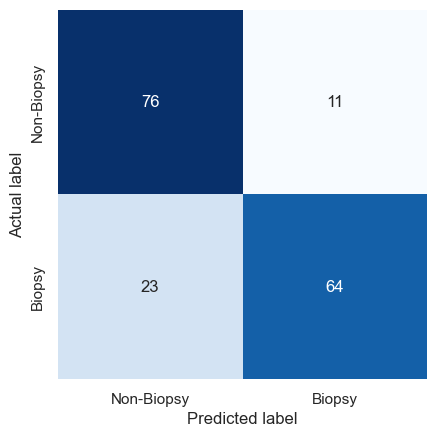

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

y_predicted = model.predict(X_test)

mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1))

#class_labels = ["Healthy",'Non-Biopsy ', 'Biopsy']
#class_labels = ["Healthy",'Non-Biopsy / Biopsy']
class_labels = ['Non-Biopsy','Biopsy']


sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
             xticklabels=class_labels,
             yticklabels=class_labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

plt.savefig(stage+'heatmap.png')


In [62]:
np.save(stage+'X_train.npy', X_train)
np.save(stage+'y_train.npy', y_train)

np.save(stage+'X_test.npy', X_test)
np.save(stage+'y_test.npy', y_test)

np.save(stage+'X_val.npy', X_val)
np.save(stage+'y_val.npy', y_val)

0.8604651093482971


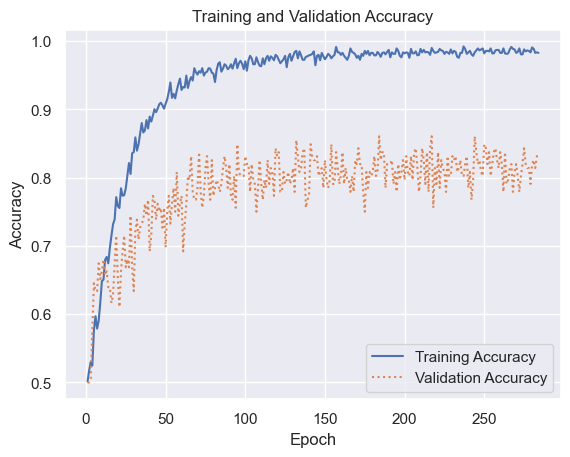

In [63]:
import matplotlib.pyplot as plt

acc = hist.history['categorical_accuracy']
val_acc = hist.history['val_categorical_accuracy']
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.plot()

plt.savefig(stage+'graph.png')

best_score = max(hist.history['val_categorical_accuracy'])

print(best_score)